In [1]:
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7dd5aa253acfeb6622b1d154ac365d33590d9319d7b21d22f6def57d2dbb9cc3
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [2]:
# matplolibを表示できるようにする
%matplotlib inline

# ライブラリのインポート
import pandas as pd;                import numpy as np
import matplotlib.pyplot as plt;    import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import xgboost as xgb
import pickle

In [3]:
# CSVファイルを読み込む
df=pd.read_csv('2015.csv')

# 変数dfの中身を表示する
print('==先頭==')
display(df.head())
print('==末尾==')
display(df.tail())
print('行列数',df.shape)

# 各列の欠損値の件数を表示する
print('欠損値確認:')
print(df.isnull().sum())

==先頭==


,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


==末尾==


,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
153,Rwanda,Sub-Saharan Africa,154,3.465,0.03464,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,0.67042
154,Benin,Sub-Saharan Africa,155,3.340,0.03656,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,1.63328
155,Syria,Middle East and Northern Africa,156,3.006,0.05015,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858
156,Burundi,Sub-Saharan Africa,157,2.905,0.08658,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302
157,Togo,Sub-Saharan Africa,158,2.839,0.06727,0.20868,0.13995,0.28443,0.36453,0.10731,0.16681,1.56726


行列数 (158, 12)
欠損値確認:
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64


In [4]:
# 特徴量と目的変数を選択
X = df[['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
        'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']]
y = df['Happiness Score']

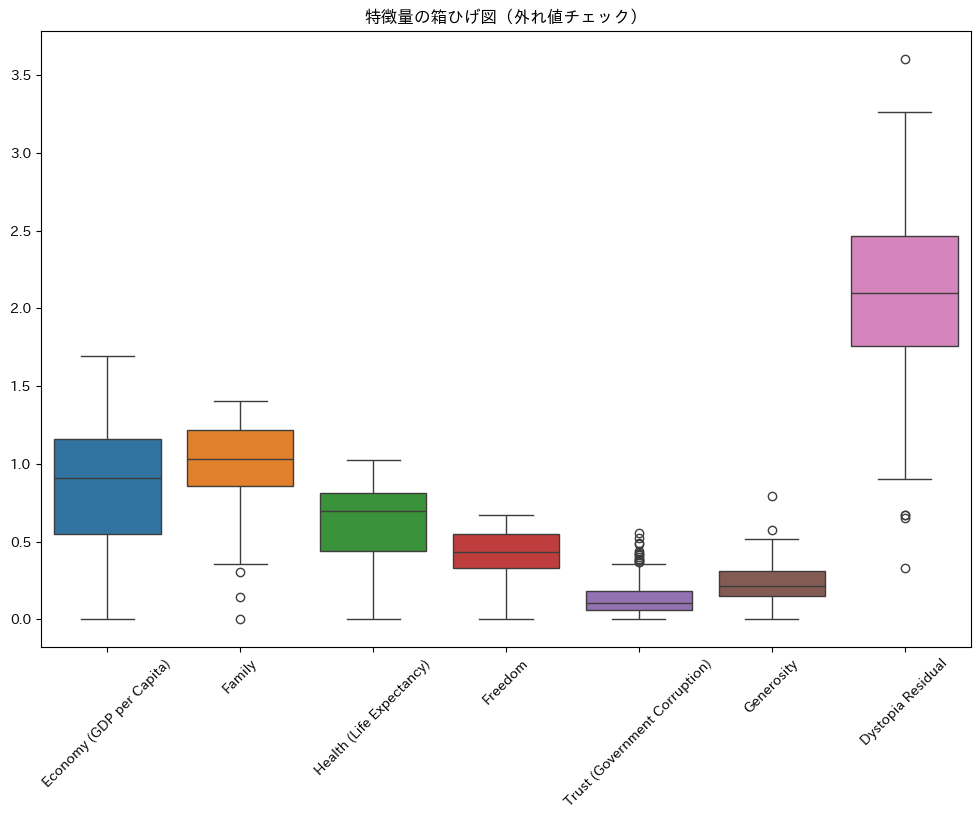

外れ値除去後のデータサイズ: (126, 12)


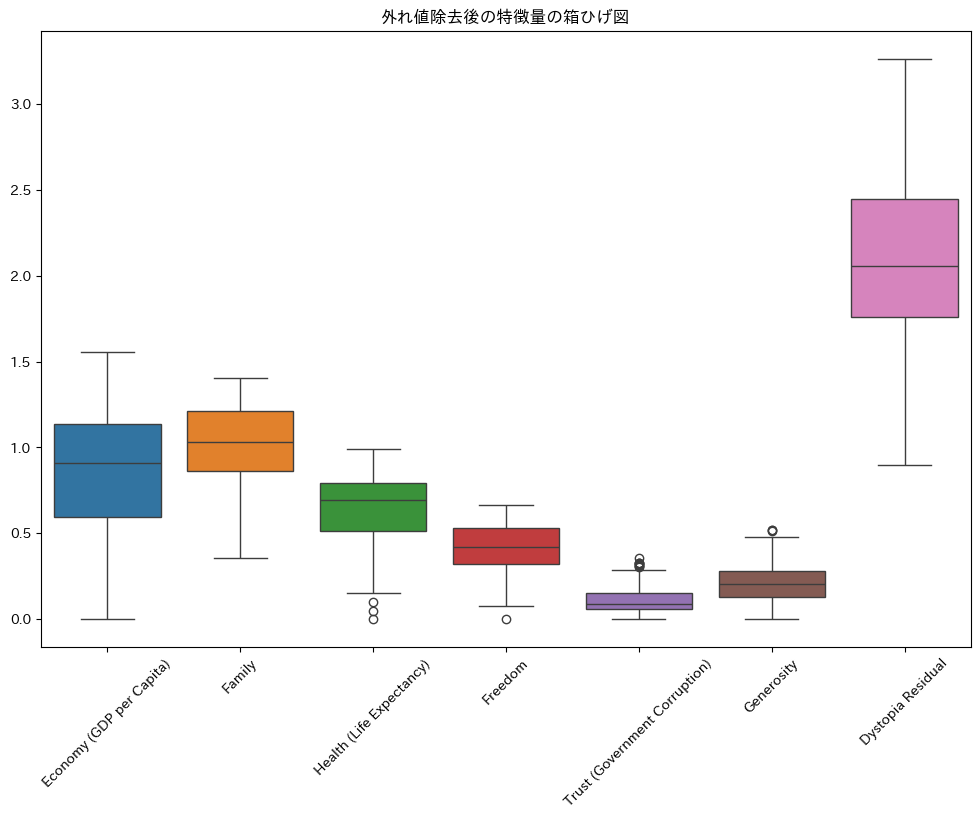

In [5]:
# 外れ値の可視化
plt.figure(figsize=(12,8))
sns.boxplot(data=X)
plt.title('特徴量の箱ひげ図（外れ値チェック）')
plt.xticks(rotation=45)
plt.show()

# 外れ値除去（IQRを使用）
def remove_outliers_iqr(data):
    # 数値型だけ取り出す
    numeric_data = data.select_dtypes(include=np.number)

    # IQRを計算
    Q1 = numeric_data.quantile(0.25)
    Q3 = numeric_data.quantile(0.75)
    IQR = Q3 - Q1

    # 外れ値ではない行を取得
    filtered_indices = ~((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)

    # 元のデータの中で、外れ値のない行だけ返す
    return data.loc[filtered_indices]

df_clean = remove_outliers_iqr(df)
print('外れ値除去後のデータサイズ:', df_clean.shape)

# 外れ値除去後の箱ひげ図
columns_order = X.columns.tolist()
df_clean_numeric = df_clean.select_dtypes(include=np.number)
df_clean_numeric = df_clean_numeric.reindex(columns=columns_order)

plt.figure(figsize=(12,8))
sns.boxplot(data=df_clean_numeric)
plt.title('外れ値除去後の特徴量の箱ひげ図')
plt.xticks(rotation=45)
plt.show()


In [6]:
# 外れ値除去後のXとy再定義
X = df_clean[['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
              'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']]
y = df_clean['Happiness Score']

In [7]:
# データ分割：80% 訓練データ、20% テストデータ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 特徴量の標準化（線形回帰）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# 線形回帰モデルの学習・予測
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [10]:
# モデル評価
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("=== 線形回帰 ===")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R2スコア: {r2_lr:.4f}")
print()

=== 線形回帰 ===
RMSE: 0.00
R2スコア: 1.0000



In [11]:
# ランダムフォレスト回帰モデルの学習・予測
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [12]:
# モデル評価
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("=== ランダムフォレスト回帰 ===")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2スコア: {r2_rf:.4f}")
print()

=== ランダムフォレスト回帰 ===
RMSE: 0.32
R2スコア: 0.8942



In [13]:
# XGBoost回帰モデルの学習・予測
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [14]:
# モデル評価
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("=== XGBoost回帰 ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R2スコア: {r2_xgb:.4f}")
print()

=== XGBoost回帰 ===
RMSE: 0.33
R2スコア: 0.8893



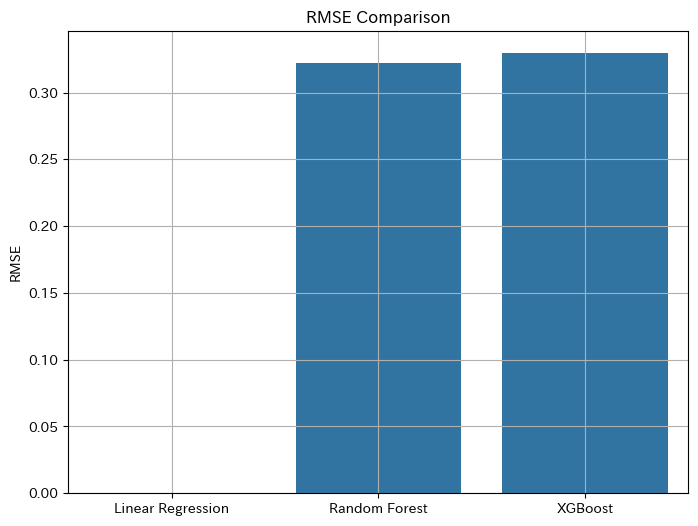

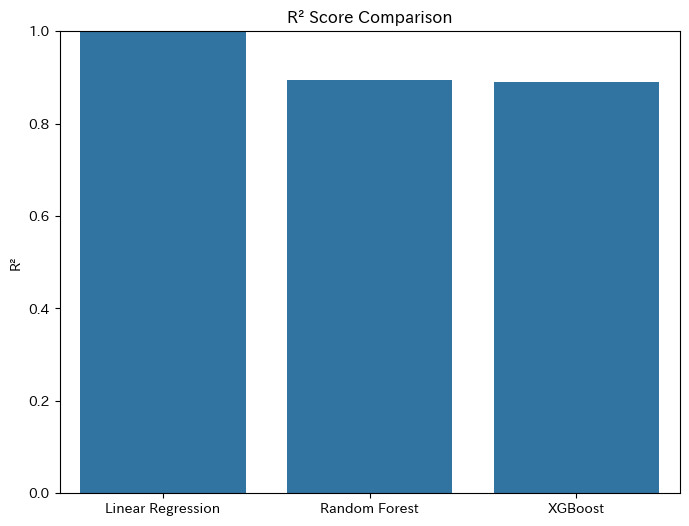

In [15]:
# 評価結果を可視化
models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_scores = [rmse_lr, rmse_rf, rmse_xgb]
r2_scores = [r2_lr, r2_rf, r2_xgb]

# RMSEの棒グラフ
plt.figure(figsize=(8,6))
sns.barplot(x=models, y=rmse_scores)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# R²の棒グラフ
plt.figure(figsize=(8,6))
sns.barplot(x=models, y=r2_scores)
plt.title('R² Score Comparison')
plt.ylabel('R²')
plt.ylim(0, 1)
plt.show()

In [16]:
# K-Fold交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 線形回帰 (標準化後)
cv_scores_lr = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')
print(f'Linear Regression Cross-Validation R²: {cv_scores_lr.mean():.4f}')

# ランダムフォレスト回帰
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
print(f'Random Forest Cross-Validation R²: {cv_scores_rf.mean():.4f}')

# XGBoost回帰
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')
print(f'XGBoost Cross-Validation R²: {cv_scores_xgb.mean():.4f}')

Linear Regression Cross-Validation R²: 1.0000
Random Forest Cross-Validation R²: 0.8839
XGBoost Cross-Validation R²: 0.8617


In [17]:
# ランダムフォレストのハイパーパラメータ調整
param_grid = {'n_estimators': [50, 100, 150, 200, 300, 400, 500]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=kf, scoring='r2')
grid_search.fit(X, y)

best_rf = grid_search.best_estimator_
print("最適なランダムフォレストの木の本数:", grid_search.best_params_['n_estimators'])

最適なランダムフォレストの木の本数: 200


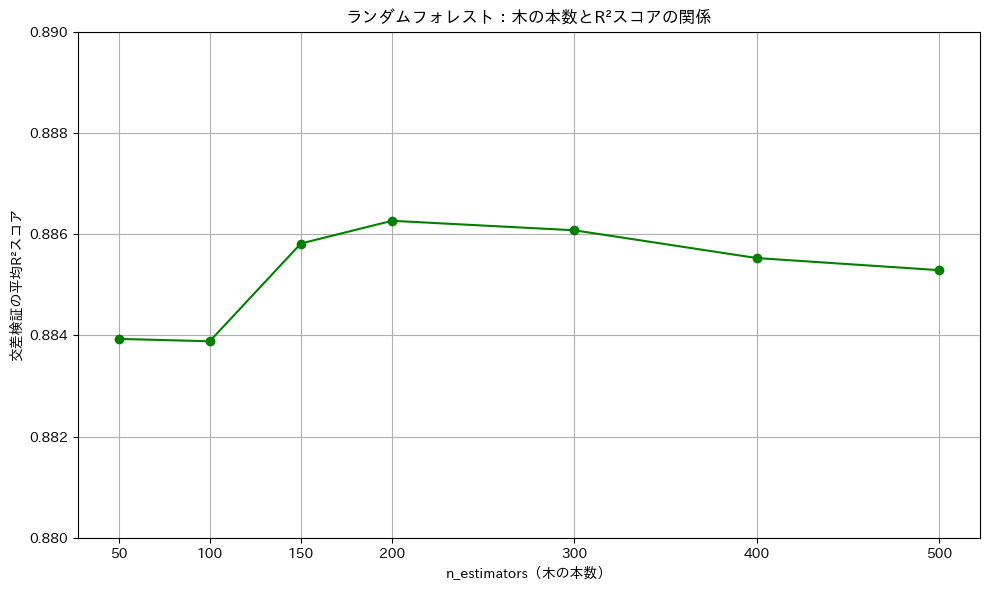

In [18]:
# 各 n_estimators に対する交差検証スコアの平均値を取得
results = grid_search.cv_results_
estimators = param_grid['n_estimators']
mean_test_scores = results['mean_test_score']

# グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(estimators, mean_test_scores, marker='o', linestyle='-', color='green')
plt.title('ランダムフォレスト：木の本数とR²スコアの関係')
plt.xlabel('n_estimators（木の本数）')
plt.ylabel('交差検証の平均R²スコア')
plt.grid(True)
plt.xticks(estimators)
plt.ylim(0.88, 0.89)
plt.tight_layout()
plt.show()

In [19]:
# ランダムフォレスト（木の本数＝200）で再学習
rf_model_200 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model_200.fit(X_train, y_train)

# テストデータで予測
y_pred_rf_200 = rf_model_200.predict(X_test)

# テスト評価
mse_rf_200 = mean_squared_error(y_test, y_pred_rf_200)
rmse_rf_200 = sqrt(mse_rf_200)
r2_rf_200 = r2_score(y_test, y_pred_rf_200)

print(f'ランダムフォレスト（200本） テストR²: {r2_rf_200:.4f}')
print(f'ランダムフォレスト（200本） RMSE: {rmse_rf_200:.4f}')

# 5-Fold交差検証
cv_scores_rf_200 = cross_val_score(rf_model_200, X, y, cv=kf, scoring='r2')
print(f'ランダムフォレスト（200本） 交差検証R²: {cv_scores_rf_200.mean():.4f}')

ランダムフォレスト（200本） テストR²: 0.8933
ランダムフォレスト（200本） RMSE: 0.3233
ランダムフォレスト（200本） 交差検証R²: 0.8863


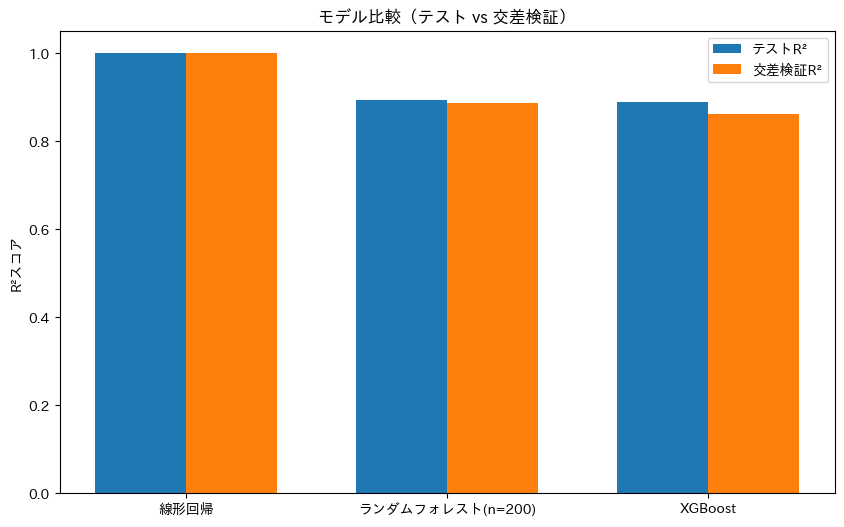

In [20]:
# モデル評価結果の可視化
models = ['線形回帰', 'ランダムフォレスト(n=200)', 'XGBoost']
r2_scores = [r2_lr, r2_rf_200, r2_xgb]
cv_r2_scores = [cv_scores_lr.mean(), cv_scores_rf_200.mean(), cv_scores_xgb.mean()]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, r2_scores, width, label='テストR²')
plt.bar(x + width/2, cv_r2_scores, width, label='交差検証R²')
plt.xticks(x, models)
plt.ylabel('R²スコア')
plt.title('モデル比較（テスト vs 交差検証）')
plt.legend()
plt.show()

In [22]:
# モデルを保存
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model_200, f)

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# スケーラーを保存（線形回帰）
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print('モデル保存完了(linear_regression_model.pkl, random_forest_model.pkl, xgboost_model.pkl)')

モデル保存完了(linear_regression_model.pkl, random_forest_model.pkl, xgboost_model.pkl)
